# The 3 ingredients of a classifier: the model, the loss, and the optimizer

We will use extensively numpy, pandas, and matplotlib libraries over the lectures.

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### 1. Let's build a simple dataset

We will first take a subset of data of the iris dataset. It will simplify and allow to come with some intuitions. We will select the sepal length and width.

In [22]:
from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris.data, iris.target

In [23]:
X = X[:, :2]

In addition, we will use only the samples corresponding to the class `0` and `1`.

In [24]:
mask_class_0_1 = np.bitwise_or(y == 0, y == 1)

In [25]:
X = X[mask_class_0_1]
y = y[mask_class_0_1]

We can make a scatter of those data.

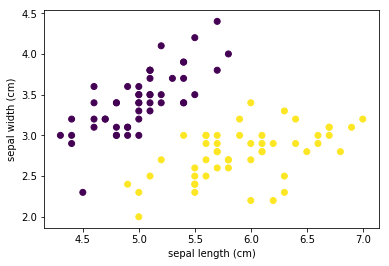

In [26]:
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1]);

## 2. The model: case of a linear classifier

A classifier can be seen as a function $f(\cdot)$ such that given $\mathbf{x}$ (i.e., a row of the matrix `X`) will return $y$ (i.e., the class of the flower). So basically, we have $f(\mathbf{x}) = y$.

When we deal with a linear classifier, it means that the function $f(\mathbf{x})$ is a linear combination of the input features (i.e., sepal width adn sepal length). Therefore, we can formulate this as $f(\mathbf{x}) = \mathbf{w} \cdot \mathbf{x}$. Sometimes, an extra parameter is included avoiding the function to pass by the origin: the bias. The function is then represented by $f(\mathbf{x}) = \mathbf{w} \cdot \mathbf{x} + b$

Intuitevely, in our previous example it means that $f(\mathbf{x})$ can be represented by a line (in higher dimension it will be an hyperplane) which will separate the data into two classes.

### Questions

* Define a pair of points which separate the two classes. Plot a line joining these points.

In [27]:
decision_points = np.array(
    [[4.0, 2.0],
     [7.2, 4.5]]
)

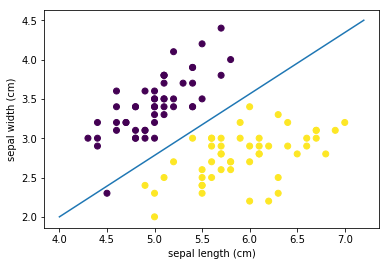

In [28]:
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1]);
plt.plot(decision_points[:, 0], decision_points[:, 1]);

We recall that a linear classifier is defined the function $f(\mathbf{x}) = \mathbf{w} \cdot \mathbf{x} + b$

* From the pair of points that you defined previously, how do you compute the associated weight with the decsion function defined by the pair of points? Hint: You can look at `numpy.linalg.solve`.

In [29]:
coefs = np.linalg.solve(decision_points,
                        np.ones(shape=(decision_points.shape[0], 1)))
coefs

array([[ 0.69444444],
       [-0.88888889]])

We could also inverse the function to find $\mathbf{w}$ such that $\mathbf{w} = \mathbf{x}^{-1} \cdot \mathbf{b}$

In [30]:
coefs = np.dot(np.linalg.inv(decision_points),
               np.ones(shape=(decision_points.shape[0], 1)))
coefs

array([[ 0.69444444],
       [-0.88888889]])

* Using the coefficients that you computed, define a function which would compute the distance to the line. Hint: this is basically the function of a linear classifier.

In [31]:
def decision_function(X, coefs, intercept):
    return np.dot(X, coefs) + intercept

* Take the first sample of the dataset and compute the distance to the line. Check also the sign which will let you know on which side of the line the point will lie.

In [32]:
sample = X[0]
decision_function(sample, coefs, -1)

array([-0.56944444])

Therefore, knowing these coefficient we can actually create a linear classifier which can automatically tell us on which side of the line we are.

In [34]:
class ManualLinearClassifier:
    def __init__(self, decision_points):
        self.decision_points = decision_points
    
    def fit(self, X, y):
        dummy_feature = np.ones(shape=(self.decision_points.shape[0], 1))
        self.intercept_ = -1
        self.coefs_ = np.linalg.solve(self.decision_points, dummy_feature)
        
    def decision_function(self, X):
        return (np.dot(X, self.coefs_) + self.intercept_).ravel()

So now we can create a classifier and call the appropriate function to compute the distance to the line.

In [35]:
clf = ManualLinearClassifier(decision_points)
clf.fit(X, y)

In [27]:
clf.decision_function(np.array([[5.0, 2.0]]))

array([0.69444444])

We can plot the line corresponding to $\mathbf{w} \cdot \mathbf{x} + b = 0$ which should be our line.

In [46]:
def plot_2d_separator(classifier, X, ax=None, levels=None, eps=None):
    eps = X.std() / 2. if eps is None else eps
    levels = [0] if levels is None else levels
    ax = plt.gca() if ax is None else ax
    
    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx = np.linspace(x_min, x_max, 100)
    yy = np.linspace(y_min, y_max, 100)

    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]
    decision_values = classifier.decision_function(X_grid)
    CS = ax.contour(X1, X2, decision_values.reshape(X1.shape), levels=levels)
    ax.clabel(CS, inline=1, fontsize=10)

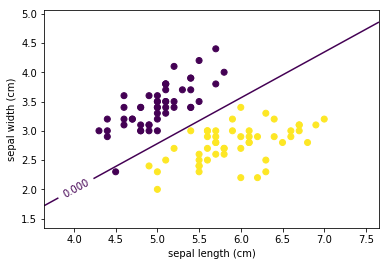

In [47]:
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1]);
plot_2d_separator(clf, X, levels=[0])

We can also plot different distance ranging from -5 to 5.

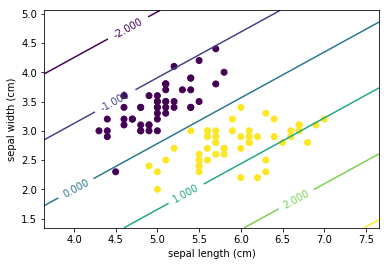

In [48]:
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1]);
plot_2d_separator(clf, X, levels=np.arange(-5, 5, 1))

### Questions

* Modify the previous classifier class to add a `predict_proba` function. This function should apply a sigmoid function on the output of the `decision_function` to output probabilities. Beaware that we expect the probablity to belong to the class 0 and to the class 1.

In [55]:
class ManualLinearClassifier:
    def __init__(self, decision_points):
        self.decision_points = decision_points
    
    def fit(self, X, y):
        dummy_feature = np.ones(shape=(self.decision_points.shape[0], 1))
        self.intercept_ = -1
        self.coefs_ = np.linalg.solve(self.decision_points, dummy_feature)
        
    def decision_function(self, X):
        return (np.dot(X, self.coefs_) + self.intercept_).ravel()

    @staticmethod
    def _sigmoid(X):
        return 1 / (1 + np.exp(-X))
    
    def predict_proba(self, X):
        prob = self._sigmoid(self.decision_function(X))
        return np.vstack((1 - prob, prob)).T

In [56]:
clf = ManualLinearClassifier(decision_points)
clf.fit(X, y)

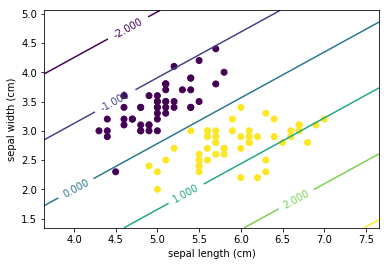

In [57]:
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1]);
plot_2d_separator(clf, X, levels=np.arange(-5, 5, 1))

In [60]:
print('Decision function: ',
      clf.decision_function(np.array([[5.0, 2.0]])))
print('Probability: ',
      clf.predict_proba(np.array([[5.0, 2.0]])))

Decision function:  [0.69444444]
Probability:  [[0.33304511 0.66695489]]


* Implement a `predict` method which should threshold the probability and output only the correct label. You can use the sign of the `decision_function` for instance.

In [61]:
class ManualLinearClassifier:
    def __init__(self, decision_points):
        self.decision_points = decision_points
    
    def fit(self, X, y):
        dummy_feature = np.ones(shape=(self.decision_points.shape[0], 1))
        self.intercept_ = -1
        self.coefs_ = np.linalg.solve(self.decision_points, dummy_feature)
        
    def decision_function(self, X):
        return (np.dot(X, self.coefs_) + self.intercept_).ravel()

    @staticmethod
    def _sigmoid(X):
        return 1 / (1 + np.exp(-X))
    
    def predict_proba(self, X):
        prob = self._sigmoid(self.decision_function(X))
        return np.vstack((1 - prob, prob)).T
    
    def predict(self, X):
        dist = np.sign(self.decision_function(X))
        dist[dist < 0] = 0
        return dist.astype(int)

In [62]:
clf = ManualLinearClassifier(decision_points)
clf.fit(X, y)

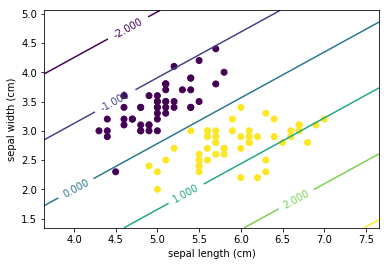

In [63]:
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1]);
plot_2d_separator(clf, X, levels=np.arange(-5, 5, 1))

In [66]:
print('Decision function: ',
      clf.decision_function(np.array([[5.0, 2.0]])))
print('Probability: ',
      clf.predict_proba(np.array([[5.0, 2.0]])))
print('Label: ',
      clf.predict(np.array([[5.0, 2.0]])))

Decision function:  [0.69444444]
Probability:  [[0.33304511 0.66695489]]
Label:  [1]


* Compute the accuracy of our classifier on the whole dataset. You can import the function `sklearn.metrics.accuracy_score`.

In [69]:
from sklearn.metrics import accuracy_score
clf = ManualLinearClassifier(decision_points)
clf.fit(X, y)
print('The mean accuracy is: ', accuracy_score(y, clf.predict(X)))

The mean accuracy is:  0.99


## 3. The duo loss-optimizer

Up to now, we create a classifier and define the "decision rule" by hand. However, machine learning provides algorithms and tools to learn these decision rules directly from the data.

The learning phase is done through optimization: we try to minimize or maximize an objective function. When minimizing the function, this function is called a cost or loss function.

In [54]:
from sklearn.metrics import log_loss


class LogisticRegression:
    
    def __init__(self, learning_rate=0.1, max_iter=100, tol=1e-3,
                 batch_size=20):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
        self.batch_size = batch_size
    
    def _sigmoid(self, X):
        """Define the sigmoid function."""
        return 1 / (1 + np.exp(-X))
    
    def _decision_function(self, X):
        """Define our decision function.
        
        Our decision function is a linear function such that:
        
        f(X) = X . W
        
        We assume that a dummy column is added to X to fit the
        intercept.
        """
        return np.dot(X, self.coefs_)
    
    def _grad_nll(self, X, y):
        """Define the gradient of our loss function.
        
        Our loss function is the negative loglikelihood. The gradient
        is defined as:
        
        dnll = X.T (y_pred - y_true)
        """
        grad = (self._predict_proba(X) - y)
        return np.dot(X.T, grad)
    
    def _add_intercept(self, X):
        return np.hstack((X, np.ones(shape=(X.shape[0], 1))))

    def fit(self, X, y):
        X = self._add_intercept(X)
        # Make y to be a column vector for later operation
        y = np.atleast_2d(y).T
        # Initialize randomly the weights
        self.coefs_ = np.random.rand(X.shape[1], 1)
        
        it = 0
        loss = np.inf
        while it < self.max_iter and loss > self.tol:
            # select a minibatch
            idx = np.random.choice(np.arange(X.shape[0]),
                                   size=self.batch_size)
            X_subset, y_subset = X[idx], y[idx]
            # compute the gradient
            dnll = self._grad_nll(X_subset, y_subset)
            # update the parameter
            self.coefs_ -= (self.learning_rate / X_subset.shape[0]) * dnll
            # update the loss and the number of iteration
            loss = log_loss(y, self._predict_proba(X))
            it += 1
        return self
    
    def _predict_proba(self, X):
        return self._sigmoid(self._decision_function(X))
    
    def predict_proba(self, X):
        X = self._add_intercept(X)
        return self._predict_proba(X)

    def predict(self, X):
        prob = self.predict_proba(X)
        prob[prob < 0.5] = 0
        prob[prob >= 0.5] = 1
        return prob.astype(int).ravel()
    
    def score(self, X, y):
        return np.mean(y == self.predict(X))

In [51]:
clf = LogisticRegression(learning_rate=0.1)

In [52]:
clf.fit(X.values, y)

100


In [53]:
clf.score(X, y)

0.99